# $l_1$--regularization
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to minimize:
$$
\min_x \frac 1 2 ||Ax-b||^2 + \lambda  ||x||_1 =: F(x)=f(Ax)+g(x),
$$
where $A\in \R^{m\times n}$ is a matrix data, $b\in \R^m$ is a given observation, and $x\in \R^n$ is an unknown signal.

We can rewrite the problem above in a primal-dual form as follows:
$$
\min_x \max_y g(x)+(Ax,y)-f^*(y),
$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$ and $g(x) = \lambda ||x||_1$.

For the problem in a primal-dual form we apply primal-dual methods.

In [1]:
import matplotlib.pyplot as plt
from opt_operators import *
from methods.pd_algorithms import *
from methods.gr_pd_algorithms import *
from methods.adaptive_PDAc import *
import scipy.sparse.linalg as spr_LA

We construct our data in one of the following ways below. We will use a fixed random generator for all our data to make experiments reproducible.

In [3]:
gen = 1

For the problem below we took $p = 0.5$ or $p = 0.9$

In [12]:
n = 5000
m = 1000
s = 50
la = 0.1

np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.6
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]

np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

Define $\nu$ and $b$

In [13]:
np.random.seed(gen)
nu = np.random.normal(0,0.1, m)
b = A.dot(w) + nu

Define all ingredients for primal-dual methods

In [14]:
def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)
    #return np.fmax(x, 0)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def prox_f(y, rho):
    return (y + rho*b)/(1+rho)

# define energy 
def J(x,y,min_val):
    t = A.dot(x)-b
    return np.abs(0.5* t.dot(t) + la* LA.norm(x,1)-min_val)
# We need the following in order to apply accelerated primal-dual with f^* strongly convex.
def J1(y,x,min_val):
    return J(x,y,min_val)

def J2(x, Kx):
    grad = A.T.dot(Kx-b)
    aa = LA.norm(x - prox_g(x - grad, 1))/(1+LA.norm(x)+LA.norm(grad))  
    return aa
#### Computing distance

def dis_sub(la,x,y):
    y1 = y[x>0]; y2 = y[x<0]
    if y1.size > 0 and y2.size > 0: 
        a = np.hstack((y[x>0]+la, y[x<0] - la))
    elif y1.size > 0:
        a = y[x>0]+la
    else:
        a = y[x<0] - la
           
    z = y[x==0]; 
    if z.size>0:
        z1 =np.hstack((z[z<-la],z[z>la]))
        if z1.size>0:
            a = np.hstack((a,np.minimum(np.abs(z1-la),np.abs(z1+la))))
            
    #print(a)
    b = LA.norm(a,1)
    return b

Compute matrix norm of operator $A$. This may be long if you consider large-scale problems.

In [15]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))
print(L**2)
# starting points
x0 = np.zeros(n)
y0 = -b

22738.9943475595


Get an approximation of the optimal value $F^*$

In [16]:
# number of iterations
N = 30000
min_val = 0
phi_f = 1.8
delta = phi_f*(2+2*phi_f-phi_f**2)/(1+phi_f)
sqrt_delta = np.sqrt(delta) 

ratio = 1
kk = 10
tau_f = 1/ratio * kk * sqrt_delta/L      
sigma_f = ratio * kk * sqrt_delta/L 

T_pd = 1e-8
ans03 = pd_free_Golden_all(J, prox_g, prox_f_conj,dis_sub, A, x0, y0, sigma_f, tau_f, phi_f, min_val,la,b, numb_iter=N, tol=T_pd)

t = A.dot(ans03[1])-b
min_val = 0.5* t.dot(t) + la* LA.norm(ans03[1],1)
print(min_val)

T = 1e-12
ans4 = pd_free_PDAc_adaptive_LASSO(J, prox_g, prox_f_conj, dis_sub, A, x0, y0, sigma_f, tau_f, phi_f, min_val,la,b, numb_iter=N, tol=T)


1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 77.05
iteration:
9523
opt:
9.899790297642277e-09
error:
9.899790297642277e-09
27.656233883217602
1.517142857142857
----- Adaptive Stepfree PDA-----
Time execution: 29.06
iteration:
2828


In [17]:
T = 1e-12
N = 80000

# step size for PDAc
phi = 1.8
delta = phi*(2+2*phi-phi**2)/(1+phi)
#delta = 2

sqrt_delta = np.sqrt(delta)  
ratio = 1
tau = 1/ratio * sqrt_delta/L      
sigma = ratio * sqrt_delta/L  

ans2 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau,phi, min_val, numb_iter=N,tol=T)

#gen = 1  # random generator
#np.random.seed(gen)
#prec=1e-10
#y1 = y0 + np.random.random(y0.shape) * prec
# need to fix division in case of zero in the denominator
#L1 = LA.norm(A.T.dot(y1 - y0))/ LA.norm(y1 - y0)

#tau1 = np.sqrt(1.5) / L1     # for  GRPDA-L
#ans3 = pd_Golden_linesearch_dual_is_square_norm(J, prox_g, -b, A, x0, y0, tau1, 1, min_val, numb_iter=N, tol=T)

Iter: 19109
----- Golden-Ratio PDA-----
Time execution: 138.93


In [18]:
T = 1e-12
phi_f = 1.8
delta = phi_f*(2+2*phi_f-phi_f**2)/(1+phi_f)
sqrt_delta = np.sqrt(delta) 

ratio = 1
kk = 10
tau_f = 1/ratio * kk * sqrt_delta/L    
sigma_f = ratio * kk * sqrt_delta/L

ans1 = pd_free_Golden(J, prox_g, prox_f_conj, A, x0, y0, sigma_f, tau_f, phi_f, min_val, numb_iter=N, tol=T)
#ans4 = pd_free_PDAc_adaptive_LASSO(J, prox_g, prox_f_conj, dis_sub, A, x0, y0, sigma_f, tau_f, phi_f, min_val,la,b, numb_iter=N, tol=T)
    

1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 52.1
iteration:
5132
opt:
9.912071163853398e-13
error:
9.912071163853398e-13


1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 3.56
iteration:
12533
opt:
9.983125437429408e-13
error:
9.983125437429408e-13
1.517142857142857
----- Adaptive Stepfree PDA-----
Time execution: 1.84
iteration:
4837
1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 3.3
iteration:
11520
opt:
9.983125437429408e-13
error:
9.983125437429408e-13
1.517142857142857
----- Adaptive Stepfree PDA-----
Time execution: 1.62
iteration:
4560
1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 2.81
iteration:
10654
opt:
9.947598300641403e-13
error:
9.947598300641403e-13
1.517142857142857
----- Adaptive Stepfree PDA-----
Time execution: 1.61
iteration:
4410
1.517142857142857
----- Stepfree Golden-Ratio PDA-----
Time execution: 2.69
iteration:
9899
opt:
9.983125437429408e-13
error:
9.983125437429408e-13
1.517142857142857
----- Adaptive Stepfree PDA-----
Time execution: 1.57
iteration:
4235
1.517142857142857
----- Stepfree Golden-Ratio PDA-----

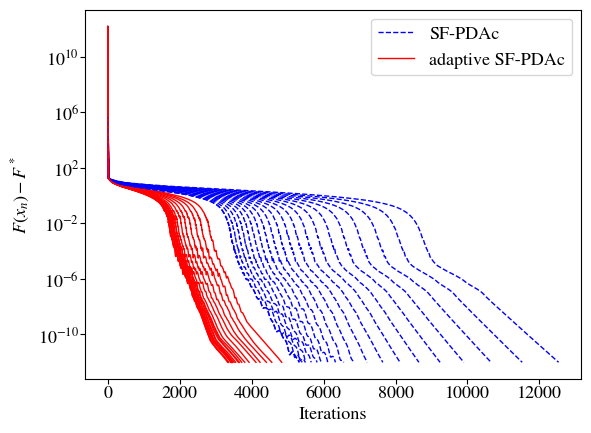

In [14]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1)
mpl.rcParams.update(
    {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1
ratio = 1

for kk in range(20):
    kk += 12
    kk *= 0.5
    tau_f = 1/ratio * kk * sqrt_delta/L    
    sigma_f = ratio * kk * sqrt_delta/L

    ans1 = pd_free_Golden(J, prox_g, prox_f_conj, A, x0, y0, sigma_f, tau_f, phi_f, min_val, numb_iter=N, tol=T)
    ans4 = pd_free_PDAc_adaptive_LASSO(J, prox_g, prox_f_conj, dis_sub, A, x0, y0, sigma_f, tau_f, phi_f, min_val,la,b, numb_iter=N, tol=T)
    
    plt.plot(ans1[0], 'b--')
    plt.plot(ans4[0], 'r')
    
plt.plot(ans1[0], 'b--', label = 'SF-PDAc')
plt.plot(ans4[0], 'r', label = 'adaptive SF-PDAc')

plt.yscale('log')
plt.xlabel(u'Iterations')
plt.ylabel('$F(x_n)-F^*$')
#plt.ylim([1e-12,1e+13])
plt.legend()
plt.savefig('figures/LR-iter.pdf')
plt.show()

In [31]:
print(L)
print(L1)

67.54785521983939
39.955551610628724


To see the plots of residual $f(Ax)+g(x) - f(Ax^*)-g(x^*)$. For simplicity, we just set $f(Ax^*)+g(x^*)$ as the smallest number among all energy values for all methods during all iterations. Alternatively, you can increase number of iterations to obtain even better ground truth solution.

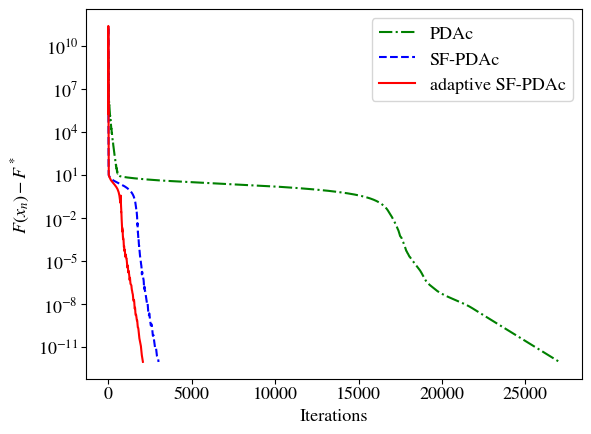

In [13]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1.5)
mpl.rcParams.update(
    {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

plt.plot(ans2[0], 'g-.', label = 'PDAc')
#plt.plot(ans3[0], 'm:',label = 'GRPDA-L')
plt.plot(ans1[0], 'b--', label = 'SF-PDAc')
plt.plot(ans4[0], 'r', label = 'adaptive SF-PDAc')



plt.yscale('log')
plt.xlabel(u'Iterations')
plt.ylabel('$F(x_n)-F^*$')
#plt.ylim([1e-12,1e+13])
plt.legend()
#plt.savefig('figures/LR1-iter.pdf')
plt.show()

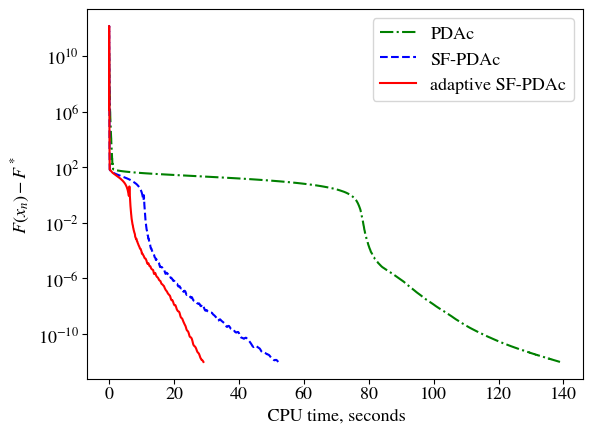

In [19]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1.5)
mpl.rcParams.update(
    {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

plt.plot(ans2[-1], ans2[0], 'g-.', label = 'PDAc')
#plt.plot(ans3[-2],ans3[0], 'm:',label = 'GRPDA-L')
plt.plot(ans1[-1], ans1[0], 'b--', label = 'SF-PDAc')
plt.plot(ans4[-1], ans4[0], 'r-', label = 'adaptive SF-PDAc')



plt.yscale('log')
plt.xlabel(u' CPU time, seconds')
plt.ylabel('$F(x_n)-F^*$')
#plt.ylim([1e-10,1e+13])
plt.legend()
plt.savefig('figures/LR2-time.pdf')
plt.show()

Nice plots as in the paper: